In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from sklearn.cluster import KMeans
from collections import Counter

train_dir = os.getcwd() + "/../train/"
train_files = os.listdir(train_dir)

# UTILS

def get_rand_img_path():
    return train_dir + random.choice(train_files)

def get_img(label):
    path = os.path.join(train_dir,f"{label}-0.png")
    img = cv2.imread(path)
    return img

def get_label(img_path):
    filename = os.path.basename(img_path)
    label = filename.split('-')[0]
    return label

def get_rand_img():
    path = get_rand_img_path()
    label = get_label(path)
    img = cv2.imread(path)
    return img, label

def show_img(img, title=None):
    plt.figure()
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

## Removing Noisy Black Lines

In [3]:
def remove_lines(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV)
    
    # Remove lines
    removed = cv2.inpaint(img, mask, 3, cv2.INPAINT_NS)
    
    return removed

## Stroke Width Separation

In [4]:
def segment_by_color_stroke_width(img, min_width=2, max_width=8, out_size=(32,32), pad_ratio=0.25):
    """
    Segment CAPTCHA characters using stroke-width + per-color separation.
    
    Returns:
        vis: image with green bounding boxes
        final_mask: merged mask of all detected regions
        boxes: list of bounding boxes
        chars: list of cropped, padded, resized character images
    """
    img_scaled = img.copy()
    h, w = img_scaled.shape[:2]
    
    # --- Step 1: Stroke-width mask (grayscale + CLAHE + edges) ---
    gray = cv2.cvtColor(img_scaled, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    
    edges = cv2.Canny(gray, 80, 150)
    dist = cv2.distanceTransform(255 - edges, cv2.DIST_L2, 3)
    mask_sw = ((dist >= min_width/2) & (dist <= max_width/2)).astype(np.uint8) * 255
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    mask_sw = cv2.morphologyEx(mask_sw, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask_sw = cv2.morphologyEx(mask_sw, cv2.MORPH_OPEN, kernel, iterations=1)
    
    # --- Step 2: Convert to HSV for color separation ---
    hsv = cv2.cvtColor(img_scaled, cv2.COLOR_BGR2HSV)
    h_chan, s_chan, v_chan = cv2.split(hsv)
    
    # --- Step 3: Detect unique hues (ignore low saturation/brightness) ---
    sat_thresh = 50
    val_thresh = 50
    mask_color = np.zeros_like(mask_sw)

    unique_hues = np.unique(h_chan[(s_chan > sat_thresh) & (v_chan > val_thresh)])

    for hue in unique_hues:
        # Compute hue difference correctly
        h_diff = np.minimum(np.abs(h_chan.astype(np.int16) - int(hue)),
                            180 - np.abs(h_chan.astype(np.int16) - int(hue)))
        hue_mask = ((h_diff <= 5) & (s_chan > sat_thresh) & (v_chan > val_thresh)).astype(np.uint8) * 255
        mask_color = cv2.bitwise_or(mask_color, hue_mask)
    
    # --- Step 4: Merge stroke-width and color masks ---
    final_mask = cv2.bitwise_or(mask_sw, mask_color)
    
    # --- Step 5: Connected components for bounding boxes ---
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(final_mask, connectivity=8)
    boxes = []
    for i in range(1, num_labels):
        x, y, bw, bh, area = stats[i]
        if area > 50 and bh > h * 0.2:
            boxes.append((x, y, bw, bh))
    boxes.sort(key=lambda r: r[0])
    
    # --- Step 6: Visualization ---
    vis = img_scaled.copy()
    for (x, y, bw, bh) in boxes:
        cv2.rectangle(vis, (x, y), (x+bw, y+bh), (0,255,0), 2)
    
    # --- Step 7: Extract characters ---
    chars = []
    for (x, y, bw, bh) in boxes:
        crop = img_scaled[y:y+bh, x:x+bw]
        max_side = max(bw, bh)
        pad = int(max_side * pad_ratio)
        crop_padded = cv2.copyMakeBorder(crop, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=[255,255,255])
        crop_resized = cv2.resize(crop_padded, out_size, interpolation=cv2.INTER_AREA)
        chars.append(crop_resized)
    
    return vis, final_mask, boxes, chars

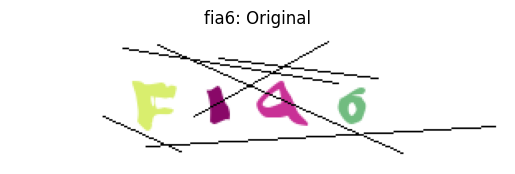

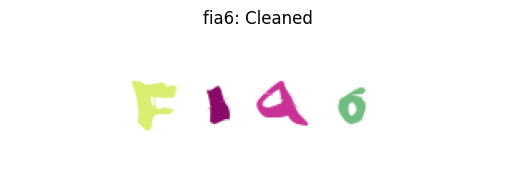

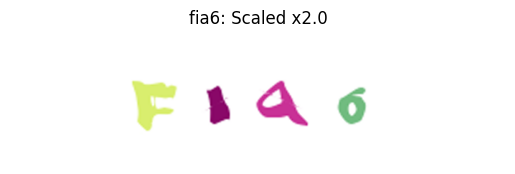

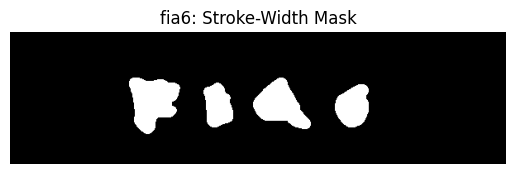

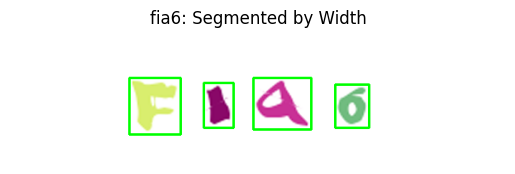

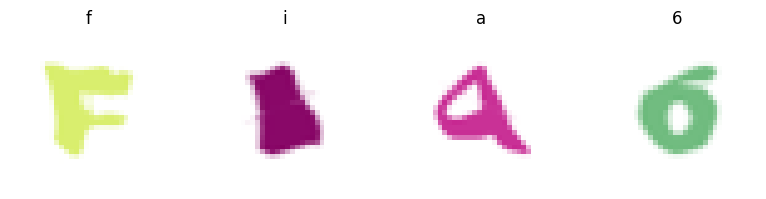

Number of characters expected: 4
Number of characters extracted: 4


In [6]:
img, label = get_rand_img()
show_img(img, title=f"{label}: Original")

img_clean = remove_lines(img)
show_img(img_clean, title=f"{label}: Cleaned")

scale = 2.0
img_scaled = cv2.resize(img_clean, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
show_img(img_scaled, title=f"{label}: Scaled x{scale}")

vis, mask, boxes, chars = segment_by_color_stroke_width(img_scaled, min_width=1, max_width=8)
show_img(mask, title=f"{label}: Stroke-Width Mask")
show_img(vis, title=f"{label}: Segmented by Width")

# --- Plot the extracted characters ---
n = len(chars)
cols = min(n, 8)
rows = (n + cols - 1) // cols

plt.figure(figsize=(cols*2, rows*2))
for i, ch in enumerate(chars):
    plt.subplot(rows, cols, i+1)
    if len(ch.shape) == 2:
        plt.imshow(ch, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(ch, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    if i < len(label):
        plt.title(label[i])
plt.tight_layout()
plt.show()

expected_len = len(label)
extracted_len = len(chars)

print("Number of characters expected:", expected_len)
print("Number of characters extracted:", extracted_len)

In [14]:
def high_pass_edges(img, method='laplacian', ksize=3):
    """
    Apply a high-pass filter to detect edges in an image.

    :param img: Input image (BGR or grayscale)
    :param method: 'laplacian' or 'sobel'
    :param ksize: Kernel size for filtering (must be odd)
    :return: Edge-detected image (grayscale)
    """
    # Convert to grayscale if needed
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()

    if method == 'laplacian':
        edges = cv2.Laplacian(gray, cv2.CV_64F, ksize=ksize)
    elif method == 'sobel':
        # Sobel in x and y directions
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
        edges = np.sqrt(sobelx**2 + sobely**2)
    else:
        raise ValueError("Method must be 'laplacian' or 'sobel'")

    # Convert back to 8-bit
    edges = cv2.convertScaleAbs(edges)

    return edges


In [48]:
def extract_outlines(edge_img, min_area=10):
    """
    Extract separate outlines from an edge image.
    
    :param edge_img: Input edge-detected image (grayscale)
    :param min_area: Minimum contour area to keep
    :return: List of ROI images for each detected outline
    """
    # Threshold to get binary mask
    _, mask = cv2.threshold(edge_img, 30, 255, cv2.THRESH_BINARY)  # 30 is arbitrary, adjust as needed

    # Optional: Morphological closing to connect broken edges
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Find external contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    rois = []
    for cnt in contours:
        if cv2.contourArea(cnt) < min_area:
            continue  # skip tiny noise
        x, y, w, h = cv2.boundingRect(cnt)
        roi = edge_img[y:y+h, x:x+w]
        rois.append(roi)

    return rois

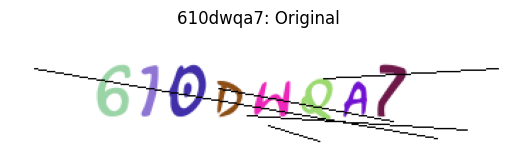

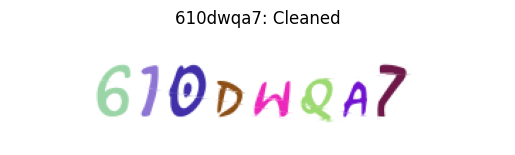

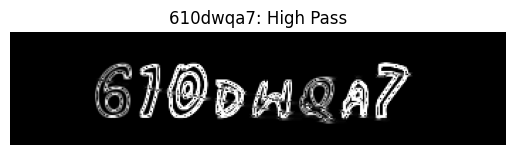

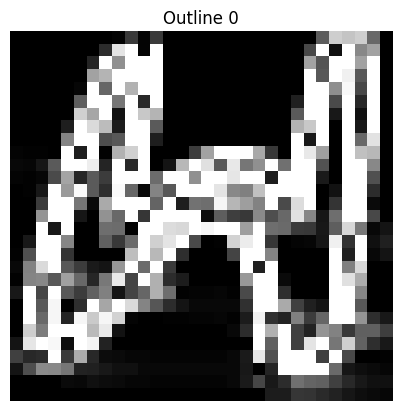

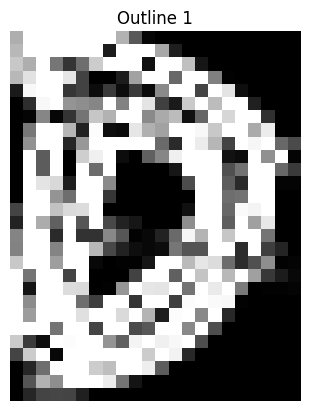

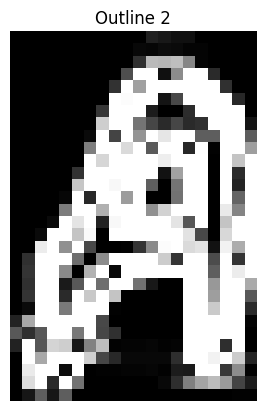

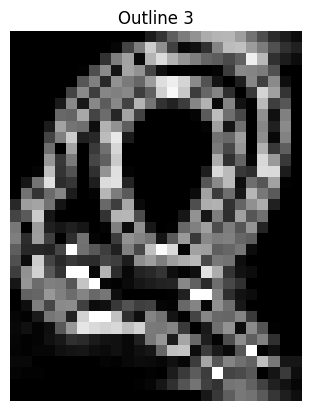

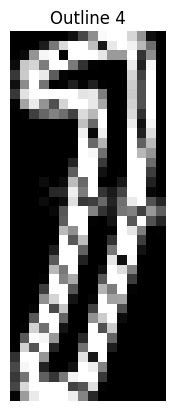

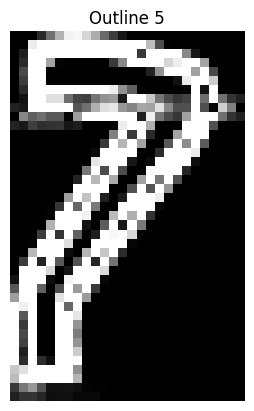

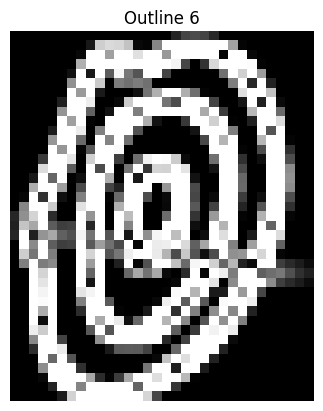

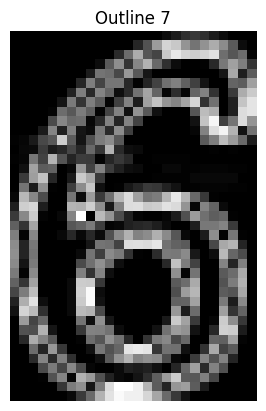

In [55]:
img, label = get_rand_img()
show_img(img, title=f"{label}: Original")

img_clean = remove_lines(img)
show_img(img_clean, title=f"{label}: Cleaned")

edges = high_pass_edges(img_clean)
show_img(edges, f"{label}: High Pass")

outlines = extract_outlines(edges)

for i, roi in enumerate(outlines):
    show_img(roi, f"Outline {i}")